In [5]:
import pymongo
import numpy as np

db = pymongo.MongoClient()['mec']
dataset = 'calzedoniajson_items_0'

df, tf = {}, {}
docs = {}
cursor = db[dataset].find(no_cursor_timeout=True).sort('_id', pymongo.ASCENDING)
size = cursor.count()
for i, doc in enumerate(cursor):
    docs[i] = {'d': doc['_id'], 'tags': []}
    try:
        tags = doc['clarifai_tags']
        probs = doc['clarifai_probs']
        docs[i]['tags'] = tags
        for j, tag in enumerate(tags):
            try:
                posting = tf[tag]
            except KeyError:
                posting = {}
            posting[i] = {'raw_tf': 1, 'prob': probs[j], 
                            'norm_p': probs[j] / max(probs),
                           'freq': 1.0 / len(tags)}
            tf[tag] = posting
            try:
                df[tag]['df'] += 1
            except KeyError:
                df[tag] = {'df': 1.0}
            df[tag]['idf'] = np.log(1 + float(size) / df[tag]['df'])  
    except KeyError:
        pass
cursor.close()


In [7]:
def get_tf(tag, doc, metric='norm_p'):
    try:
        w = tf[tag][doc][metric]
    except KeyError:
        w = 0.0
    return w

def get_idf(tag, metric='idf'):
    try:
        w = df[tag][metric]
    except KeyError:
        w = 0.0
    return w

def bag(doc, tfm='norm_p', idfm='idf'):
    try:
        tgs = docs[doc]['tags']
        b = np.array([get_tf(x, doc, metric=tfm) * get_idf(x, metric=idfm)
                     for x in tgs])
    except KeyError:
        tgs = []
        b = np.array([])
    return tgs, b

def get_posting(tag, tfm='norm_p', idfm='idf'):
    p = []
    idf = get_idf(tag, metric=idfm)
    try:
        pd = tf[tag]
        for d, m in pd.items():
            p.append((d, m[tfm]*idf))
    except KeyError:
        pass
    return sorted(p, key=lambda x: -x[0])

# print get_posting('girl')
    

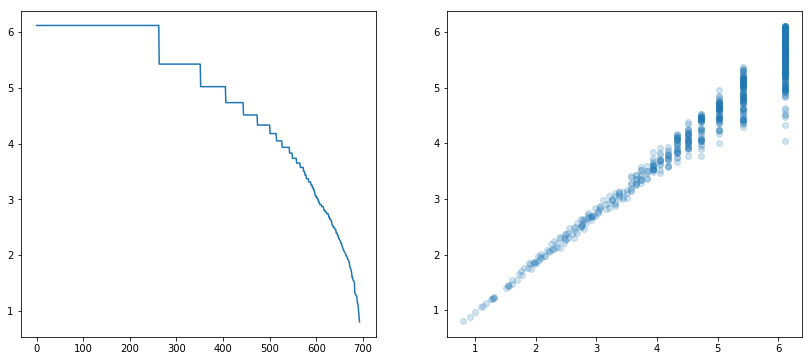

In [8]:
tag_list = tf.keys()
tag_len, tag_avg_w, tag_idf = [], [], []
for t in tag_list:
    p = get_posting(t)
    tag_len.append(len(p))
    tag_avg_w.append(np.mean([x[1] for x in p]))
    tag_idf.append(get_idf(t))

idf_y, w_y, l_y = [], [], []
for i, x in sorted(enumerate(tag_idf), key=lambda x: -x[1]):
    idf_y.append(x)
    w_y.append(tag_avg_w[i])
    l_y.append(max(tag_len[i:]))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].plot(idf_y)
axes[1].scatter(idf_y, w_y, alpha=0.2)
plt.show()


In [47]:
def eucl_norm(lst):
    return np.sqrt(np.sum(map(lambda z: z**2, lst)))

def cosine(d1, d2):
    b1, w1 = bag(d1)
    b2, w2 = bag(d2)
    
    common_tags = [d for d in b1 if d in b2]
    m1 = np.array(map(lambda t: w1[b1.index(t)], common_tags))
    m2 = np.array(map(lambda t: w2[b2.index(t)], common_tags))
    e = eucl_norm(w1) * eucl_norm(w2)
    if e > 0:
        return np.sum((m1 * m2)/e)
    else:
        return 0.0

print cosine(0,1) 

0.102407965697


In [49]:
def naive_matching(d1):
    mappings = []
    for d in docs.keys():
        if d != 1:
            mappings.append((d, cosine(d1, d)))
    return sorted(mappings, key=lambda x: -x[1])

# Inefficienze:
# scorro tutti i documenti, anche quelli senza tag in comune
# ricalcolo la bag of words di tanti elementi che non mi serviranno mai

In [51]:
def almost_matching(d1):
    result = {}
    score = {}
    tags, w = bag(d1)
    for j, t in enumerate(tags):
        d_w = w[j]
        for doc_id, v in get_posting(t):
            if doc_id != d1:
                try:
                    result[doc_id]
                except KeyError:
                    result[doc_id] = []
                result[doc_id].append((v, d_w))
    
    for doc_id, lst in result.items():
        m1 = np.array(map(lambda x: x[0], lst))
        m2 = np.array(map(lambda x: x[1], lst))
        score[doc_id] = np.sum((m1 * m2)/(eucl_norm(m1)*eucl_norm(m2)))
    return sorted(score.items(), key=lambda x: -x[1])

# In questo caso la cosine similarity è calcolata in modo sbagliato perché eucl_norm è applicato solo ai pesi dei tag comuni e non a tutti a quelli associati al documento
# Posso aggiungermi nella posting il n. di tag di ciascun documento oppure posso salvarmi a livello di documento la sua eucl_norm


In [ ]:
# Verifichiamo la similutidine tra i tag
# Costruiamo una bag of words con spazio tag e vettore documento

def tag_bag(tag, tfm='norm_p', idfm='idf'):
    dcs, prbs = [], []
    idf = get_idf(tag, metric=idfm)
    try:
        pd = tf[tag]
        for d, m in pd.items():
            dcs.append(d)
            prbs.append(m[tfm]*idf)
    except KeyError:
        pass
    return dcs, prbs

print tag_bag('fashion')

In [61]:
def tag_cosine(t1, t2):
    p1 = dict(get_posting(t1))
    p2 = dict(get_posting(t2))
    L1 = sum([np.power(x,2) for x in p1.values()])
    L2 = sum([np.power(x,2) for x in p2.values()])
    e = np.sqrt(L1)*np.sqrt(L2)
    p = 0.0
    if e > 0:
        for t1, w1 in p1.items():
            try:
                w2 = p2[t1]
                p += w1*w2
            except KeyError:
                pass
        return p/e
    else:
        return 0.0

print tag_cosine('woman', 'beach')

def naive_tag_matching(t1):
    mappings = []
    for t2 in df.keys():
        if t1 != t2:
            mappings.append((t2, tag_cosine(t1,t2)))
    return sorted(mappings, key= lambda x: -x[1])

0.385666205637


In [66]:
tag_map = naive_tag_matching('wet')
for m in tag_map:
    print m[0], m[1]

pool 0.596503048491
swimming pool 0.588621747499
swimming 0.554863998181
poolside 0.512147795818
goggles 0.505933902409
resort 0.327439392146
water 0.314345852348
snorkeling 0.258853413564
underwater 0.246671490145
summer 0.238715384929
vacation 0.222563266368
enjoyment 0.215778077334
relaxation 0.205392315878
bikini 0.18834600346
fun 0.187953911432
leisure 0.187395613644
turquoise 0.185706278726
swimsuit 0.17235039452
body 0.167243073563
beach 0.156941474781
tan 0.142926540815
recreation 0.139814388264
travel 0.136146287626
hot 0.130128717585
woman 0.128035039092
sun 0.120507627648
girl 0.117296760602
sexy 0.110928798956
sunglasses 0.108128982807
erotic 0.0869416579316
beautiful 0.0795753644318
art 0.0784814594919
child 0.0780425266834
people 0.0767264221143
sport 0.0671766631849
active 0.0661665090503
nude 0.0659626322218
underwear 0.0594670204134
pantie 0.0587137331492
tropical 0.0564486934605
model 0.0545147563865
man 0.0524606522714
sand 0.0494186575986
ocean 0.0482734461533
young